In [2]:
import numpy as np
import pandas as pd

In [3]:
df = pd.read_csv('/Users/maxweber/Desktop/DataMasterThesis/full_sipp.csv')
df.drop('Unnamed: 0', inplace = True, axis=1)
df.shape

(814613, 92)

## Data Cleaning and Feature Engineering

In [4]:
df['pp'] = df.groupby(['SSUID','EPPPNUM']).ngroup()
df.set_index('pp', inplace = True)
print('unique index: ',len(df.index.unique())) #95577 unique
print('unique HH: ',len(df['SSUID'].unique()))
pp_count = df.groupby(['pp'], as_index=False).size() # columns: pp and size
pp_count

df = df.merge(pp_count, how = 'outer', on = 'pp')
df = df[df['size']== 8]
print('unique HH: ',len(df['SSUID'].unique()))
df.drop('size', axis=1, inplace = True)

df.shape # 764.616 from 814.613 before

unique index:  108280
unique HH:  42030
unique HH:  38569


(764616, 93)

unique index:  587768
unique HH:  26238


(587768, 95)

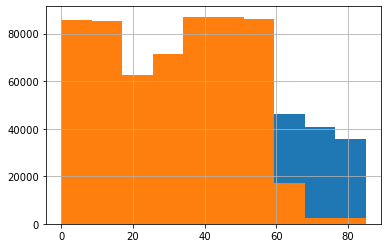

In [5]:
#Powell: I require the head of the household to be between 25 and 60 years old
# EHREFPER = EPPPNUM and TAGE => 25 and TAGE <= 60 (this can be optimized by looking at first or last month of observed timeframe)
df['TAGE'].describe()
min_tage = df.groupby(df.index)['TAGE'].min().rename('min_tage')
max_tage = df.groupby(df.index)['TAGE'].max().rename('max_tage')

df = df.merge(min_tage, how = 'left', left_index = True, right_index = True)
df = df.merge(max_tage, how = 'left', left_index = True, right_index = True)

ssuids_age = df[(df['EHREFPER'] == df['EPPPNUM']) & (df['min_tage']>= 25)  & (df['max_tage'] <= 60)]['SSUID'].unique()

df[~df['SSUID'].isin(ssuids_age)]['TAGE'].hist()
df[df['SSUID'].isin(ssuids_age)]['TAGE'].hist()
df = df[df['SSUID'].isin(ssuids_age)]
# seems reasonable. next step is to aggregate to houshold level to further reduce #of HH

print('unique index: ',len(df.index.unique()))
print('unique HH: ',len(df['SSUID'].unique()))
df.shape

In [6]:
# create the total month variable with year and month
def get_total_month(year,month):
    if year == 2009:
        return month+12
    else:
        return month
        
df['month_total'] = df.apply(lambda x: get_total_month(x['RHCALYR'],x['RHCALMN']),axis=1)

In [7]:
# correct the rebated if EREBATE = 2 -> EREBATE = 0; if EREBATE = -1 -> EREBATE = np.NaN 
print(df[~df['EREBATE'].isnull()]['EREBATE'].unique()) 
df['erebate'] = df['EREBATE'].replace({2 : 0, -1 : np.NaN})

df['erbamth'] = df['ERBAMTH'].replace(-1, np.NaN)
df['erebatoc'] = df['EREBATOC'].replace(-1, np.NaN)
df['erbattyp'] = df['ERBATTYP'].replace({2 : 0, -1 : np.NaN})

[ 2. -1.  1.]


In [8]:
# define lag_time as time relative to the month of rebate. Use this to define lag-dummies used in the regression.
df['lag_time'] =  df['month_total'] - df['erbamth']

# use on df without NaN in lag_time period
def get_pivoted_feature(df, col_name):
    rslt_df = df.pivot(columns = 'lag_time', values = col_name)
    clm_lst = []
    for i in range(len(rslt_df.columns)):
        clm_lst.append(col_name + str(str(rslt_df.columns[i])[0:-2])) # vorher: str(rslt_df.columns[i])
    rslt_df.columns = clm_lst
    return rslt_df

In [9]:
# create dummies for the rebate dummy and the month of rebate
pivoted = get_pivoted_feature(df[df['lag_time'].notnull()], 'erebate')
df = pivoted.merge(df, how = 'outer', left_index = True, right_index=True)
print(df.shape)

df[df['erebate']==1][['SSUID','EPPPNUM']]
print(df[df['SSUID']==19128038046][pivoted.columns]) # to see that the dummy pivoting works correctly

df[pivoted.columns] = df[pivoted.columns].replace(np.NaN,0)
df[df['erebate']!= 0][pivoted.columns]

(587768, 119)


,erebate-6,erebate-5,erebate-4,erebate-3,erebate-2,erebate-1,erebate0,erebate1,erebate2,erebate3,erebate4,erebate5,erebate6,erebate7,erebate8,erebate9,erebate10,erebate11
16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
807379,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
807380,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
807381,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
807382,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# clean the EREBATE<0 values as in Powell (2020):
df['tfearn'] = df['TFEARN']
df.loc[df.tfearn < 0, 'tfearn'] = 0
df[['TFEARN','tfearn']].describe()

,TFEARN,tfearn
count,587768.000000,587768.000000
mean,5652.128651,5663.891588
std,6083.003032,6061.693905
min,-46667.000000,0.000000
25%,1840.000000,1840.000000
50%,4243.000000,4243.000000
75%,7658.000000,7658.000000
max,98083.000000,98083.000000


In [11]:
# exclude cohibiting non married couples
unmarried_hh = df[(df['EMS']> 2 ) & (df['ERRP'] == 10)]['SSUID'].unique()
df = df[~df['SSUID'].isin(unmarried_hh)]
df.shape
len(df['SSUID'].unique())

# convert to dummy where married = 1, everythin else is 0.
df['ems'] = df['EMS'].replace([2,3,4,5,6],0)

In [13]:
# topcode EHHNUMPP to 6 to limit interaction terms in the FE 2SLS
df.loc[df.EHHNUMPP > 6, 'EHHNUMPP'] = 6

In [14]:
df.to_csv('/Users/maxweber/Desktop/DataMasterThesis/data_clean.csv')

# Aggregate to houshold level (SSUID)
modified/aggregated variables in lower caps

In [52]:
df = pd.read_csv('/Users/maxweber/Desktop/DataMasterThesis/data_clean.csv')

In [20]:
houshold = df.groupby(['SSUID', 'month_total'])[['SSUID', 'tfearn', 'ERBATAMT','TFTOTINC', 'month_total', 'erbamth', 'ems', 'EHHNUMPP','SREFMON', 'erebate-6', 'erebate-5', 
                                                'erebate-4', 'erebate-3', 'erebate-2','erebate-1', 'erebate0', 'erebate1', 'erebate2', 'erebate3', 'erebate4', 
                                                'erebate5', 'erebate6', 'erebate7', 'erebate8', 'erebate9', 'erebate10','erebate11']].agg({#'month_total': 'first',
                                                                                                                                            'tfearn': 'first',
                                                                                                                                            'erbamth': 'first',
                                                                                                                                            'TFTOTINC': 'first',
                                                                                                                                            'ERBATAMT': 'sum',
                                                                                                                                            'SREFMON' : 'first',
                                                                                                                                            'ems': 'first',
                                                                                                                                            'EHHNUMPP': 'first',
                                                                                                                                            'erebate-6': 'first',
                                                                                                                                            'erebate-5': 'first',
                                                                                                                                            'erebate-4': 'first',
                                                                                                                                            'erebate-3': 'first',
                                                                                                                                            'erebate-2': 'first',
                                                                                                                                            'erebate-1': 'first', 
                                                                                                                                            'erebate0': 'first',
                                                                                                                                            'erebate1': 'first',
                                                                                                                                            'erebate2': 'first', 
                                                                                                                                            'erebate3': 'first', 
                                                                                                                                            'erebate4': 'first',
                                                                                                                                            'erebate5': 'first',
                                                                                                                                            'erebate6': 'first',
                                                                                                                                            'erebate7': 'first',
                                                                                                                                            'erebate8': 'first',
                                                                                                                                            'erebate9': 'first',
                                                                                                                                            'erebate10': 'first',
                                                                                                                                            'erebate11': 'first'})
houshold[['ERBATAMT', 'tfearn', 'ems', 'EHHNUMPP']].describe()

,ERBATAMT,tfearn,ems,EHHNUMPP
count,196864.000000,196864.000000,196864.000000,196864.000000
mean,737.451601,5317.208540,0.569535,2.794940
std,629.386536,5807.721628,0.495142,1.452783
min,0.000000,0.000000,0.000000,1.000000
25%,300.000000,1670.000000,0.000000,2.000000
50%,600.000000,4000.000000,1.000000,3.000000
75%,1200.000000,7181.000000,1.000000,4.000000
max,7800.000000,98083.000000,1.000000,6.000000


In [21]:
houshold.to_csv('/Users/maxweber/Desktop/DataMasterThesis/houshold_clean.csv')

# Ad hoc analysis / data exploreation

- e.g. inconsistencies in HH information by different members of HH
- TFTOTINC > 12500 
- ...

In [932]:
# how often does the rebate information vary between wave1 and wave2

w1_topical = pd.read_csv('/Users/maxweber/Desktop/DataMasterThesis/topical_w1.csv', index_col = ['SSUID', 'EPPPNUM'])
w2_topical = pd.read_csv('/Users/maxweber/Desktop/DataMasterThesis/topical_w2.csv', index_col = ['SSUID', 'EPPPNUM'])

col_compare = ['SWAVE', 'EOUTCOME', 'EREBATE', 'ERBATAMT', 'ERBAMTH', 'ERBATTYP', 'EREBATOC']
topical = w1_topical[col_compare].merge(w2_topical[col_compare], how = 'inner', left_index = True, right_index = True)
topical

SWAVE_x  EOUTCOME_x  EREBATE_x  ERBATAMT_x  ERBAMTH_x  \
SSUID        EPPPNUM                                                          
19128000276  101            1         201          2           0         -1   
             102            1         201          2           0         -1   
             103            1         201         -1           0         -1   
19128000334  102            1         201          1         300          4   
19128000932  101            1         201          2           0         -1   
...                       ...         ...        ...         ...        ...   
955958398688 102            1         201          1        1000          9   
             103            1         201         -1           0         -1   
             104            1         201         -1           0         -1   
             105            1         201         -1           0         -1   
955958986671 101            1         201          2           0         -1   

                      ERBATTYP_x  EREBATOC_x  SWAVE_y  EOUTCOME_y  EREBATE_y  \
SSUID        EPPPNUM                                                           
19128000276  101              -1          -1        2         201          2   
             102              -1          -1        2         201          2   
             103              -1          -1        2         201         -1   
19128000334  102               2           2        2         201          1   
19128000932  101              -1          -1        2         201          2   
...                          ...         ...      ...         ...        ...   
955958398688 102               2           1        2         201          1   
             103              -1          -1        2         201         -1   
             104              -1          -1        2         201         -1   
             105              -1          -1        2         201         -1   
955958986671 101              -1          -1        2         201          2   

                      ERBATAMT_y  ERBAMTH_y  ERBATTYP_y  EREBATOC_y  
SSUID        EPPPNUM                                                 
19128000276  101               0         -1          -1          -1  
             102               0         -1          -1          -1  
             103               0         -1          -1          -1  
19128000334  102             600          4           2           2  
19128000932  101               0         -1          -1          -1  
...                          ...        ...         ...         ...  
955958398688 102             900          8           2           3  
             103               0         -1          -1          -1  
             104               0         -1          -1          -1  
             105               0         -1          -1          -1  
955958986671 101               0         -1          -1          -1  

[95888 rows x 14 columns]

In [933]:
topical['EOUTCOME_comp'] = np.where(topical['EOUTCOME_x'] == topical['EOUTCOME_y'] , 'True', 'False')
topical['EREBATE_comp'] = np.where(topical['EREBATE_x'] == topical['EREBATE_y'] , 'True', 'False')
topical['ERBATAMT_comp'] = np.where(topical['ERBATAMT_x'] == topical['ERBATAMT_y'] , 'True', 'False')
topical['ERBAMTH_comp'] = np.where(topical['ERBAMTH_x'] == topical['ERBAMTH_y'] , 'True', 'False')
topical['ERBATTYP_comp'] = np.where(topical['ERBATTYP_x'] == topical['ERBATTYP_y'] , 'True', 'False')
topical['EREBATOC_comp'] = np.where(topical['EREBATOC_x'] == topical['EREBATOC_y'] , 'True', 'False')
topical[['EOUTCOME_comp', 'EREBATE_comp', 'ERBATAMT_comp', 'ERBAMTH_comp', 'ERBATTYP_comp', 'EREBATOC_comp']]

EOUTCOME_comp EREBATE_comp ERBATAMT_comp ERBAMTH_comp  \
SSUID        EPPPNUM                                                         
19128000276  101              True         True          True         True   
             102              True         True          True         True   
             103              True         True          True         True   
19128000334  102              True         True         False         True   
19128000932  101              True         True          True         True   
...                            ...          ...           ...          ...   
955958398688 102              True         True         False        False   
             103              True         True          True         True   
             104              True         True          True         True   
             105              True         True          True         True   
955958986671 101              True         True          True         True   

                     ERBATTYP_comp EREBATOC_comp  
SSUID        EPPPNUM                              
19128000276  101              True          True  
             102              True          True  
             103              True          True  
19128000334  102              True          True  
19128000932  101              True          True  
...                            ...           ...  
955958398688 102              True         False  
             103              True          True  
             104              True          True  
             105              True          True  
955958986671 101              True          True  

[95888 rows x 6 columns]

In [946]:
print(topical.shape)
topical.dropna(axis = 0, inplace = True, thresh=3)
topical.dropna(axis = 0, inplace = True, thresh=3)
print(topical.shape)
topical[(topical['ERBAMTH_comp'] == 'False')]

(95888, 20)
(95888, 20)


SWAVE_x  EOUTCOME_x  EREBATE_x  ERBATAMT_x  ERBAMTH_x  \
SSUID        EPPPNUM                                                          
19128038099  102            1         201          1         600          5   
             103            1         201          2           0         -1   
19133000301  101            1         201          1         135          6   
19133038138  101            1         201          1         200          4   
19133038689  101            1         201          1         600          4   
...                       ...         ...        ...         ...        ...   
955925986851 101            1         201          1         300          6   
955925986857 101            1         201          1         200          9   
             102            1         201          1         200          9   
955958398688 101            1         201          1        1000          9   
             102            1         201          1        1000          9   

                      ERBATTYP_x  EREBATOC_x  SWAVE_y  EOUTCOME_y  EREBATE_y  \
SSUID        EPPPNUM                                                           
19128038099  102               2           3        2         201          1   
             103              -1          -1        2         201          1   
19133000301  101               1           1        2         201          1   
19133038138  101               2           1        2         207          1   
19133038689  101               2           2        2         201          1   
...                          ...         ...      ...         ...        ...   
955925986851 101               1           2        2         201          2   
955925986857 101               1           1        2         201          2   
             102               1           1        2         201          2   
955958398688 101               2           1        2         201          1   
             102               2           1        2         201          1   

                      ERBATAMT_y  ERBAMTH_y  ERBATTYP_y  EREBATOC_y  \
SSUID        EPPPNUM                                                  
19128038099  102             600          6           1           3   
             103             600          6           1           1   
19133000301  101             300          5           1           2   
19133038138  101             600          6           2           3   
19133038689  101               1          5           2           2   
...                          ...        ...         ...         ...   
955925986851 101               0         -1          -1          -1   
955925986857 101               0         -1          -1          -1   
             102               0         -1          -1          -1   
955958398688 101             900          8           2           3   
             102             900          8           2           3   

                     EOUTCOME_comp EREBATE_comp ERBATAMT_comp ERBAMTH_comp  \
SSUID        EPPPNUM                                                         
19128038099  102              True         True          True        False   
             103              True        False         False        False   
19133000301  101              True         True         False        False   
19133038138  101             False         True         False        False   
19133038689  101              True         True         False        False   
...                            ...          ...           ...          ...   
955925986851 101              True        False         False        False   
955925986857 101              True        False         False        False   
             102              True        False         False        False   
955958398688 101              True         True         False        False   
             102              True         True         False        False   

              

In [965]:
df[df['SSUID']==19128038099][['SSUID', 'EPPPNUM', 'TAGE','month_total', 'EREBATE', 'ERBAMTH']].sort_values(['EPPPNUM', 'month_total'])
# -> when in doubt only use data from wave2? create preferences what information to take depending on what information is available?

,SSUID,EPPPNUM,TAGE,month_total,EREBATE,ERBAMTH
64,19128038099,101,36,6.0,1.0,5.0
65,19128038099,101,36,7.0,1.0,5.0
66,19128038099,101,36,8.0,1.0,5.0
67,19128038099,101,36,9.0,1.0,5.0
68,19128038099,101,36,10.0,1.0,5.0
69,19128038099,101,36,11.0,1.0,5.0
70,19128038099,101,36,12.0,1.0,5.0
71,19128038099,101,36,13.0,1.0,5.0
72,19128038099,102,37,6.0,1.0,5.0
73,19128038099,102,37,7.0,1.0,5.0


In [1063]:
# are individuals in HH rebated at the same time?
topical[(topical['ERBAMTH_comp'] == 'False')]
df[df['SSUID']==955958398688][['SSUID', 'EPPPNUM', 'TAGE','month_total', 'EREBATE', 'ERBAMTH']].sort_values(['EPPPNUM', 'month_total'])

# -> seems to be the case

,SSUID,EPPPNUM,TAGE,month_total,EREBATE,ERBAMTH
807344,955958398688,101,41,7.0,1.0,9.0
807345,955958398688,101,41,8.0,1.0,9.0
807346,955958398688,101,42,9.0,1.0,9.0
807347,955958398688,101,42,10.0,1.0,9.0
807348,955958398688,101,42,11.0,1.0,8.0
807349,955958398688,101,42,12.0,1.0,8.0
807350,955958398688,101,42,13.0,1.0,8.0
807351,955958398688,101,42,14.0,1.0,8.0
807352,955958398688,102,37,7.0,1.0,9.0
807353,955958398688,102,37,8.0,1.0,9.0


# Code snippets for later

In [ ]:
# generate dummy for change in maritial status from EMS: 1 if married, 0 if not married or spouse not present

df['spouse'] = df['EMS'].replace(to_replace = [2,3,4,5,6], value = 0)
spouse_sum = df.groupby(['pp'])['spouse'].sum()
df = df.merge(df.groupby(['pp'])['spouse'].sum(), on = 'pp', how = 'left' )
df['spouse'] = df['spouse_x']
df['spouse_sum'] = df['spouse_y']
df.drop('spouse_x', axis = 1, inplace = True)
df.drop('spouse_y', axis = 1, inplace = True)

#houshold[['spouse', 'spouse_sum']].describe()
#houshold['spouse_sum'].unique() 

def get_change_spouse(spouse_sum):
    if spouse_sum == 0 or spouse_sum == 8 :
        return 0
    else:
        return 1
        
df['change_spouse'] = df.apply(lambda x: get_change_spouse(x['spouse_sum']),axis=1)

print(df[['change_spouse', 'spouse_sum']].describe()) # in Powell dataset the mean of change_spouse is 0.006
df.drop('spouse_sum', axis = 1, inplace = True)